<a href="https://colab.research.google.com/github/rahmanole/MDTrAnal/blob/master/KCUSUM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KCUSUM
### Experimental Branch

#### Module Imports

In [59]:
import numpy as np
import sklearn
from sklearn import metrics
import math
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
import os
import sys
#from codar.oas.MDTrSampler import MDTrSampler, svd_wrapper
import parmed
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from sklearn.utils.extmath import svd_flip, randomized_svd
import scipy.io
from scipy.sparse.linalg import svds
import scipy.ndimage as ndi
from heapq import heappush, heappop
from pprint import pprint
from random import uniform
import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)

#### Generate Reference Data

In [32]:
sample_x_0 = np.random.normal(0,1,size=2000)
sample_x_1 = np.random.normal(0,1,size=2000)


sample_y_0 = np.random.normal(0,2,size=2000)
sample_y_1 = np.random.normal(0,2,size=2000)


sample_z_0 = np.random.normal(0,2,size=2000)
sample_z_1 = np.random.normal(0,2,size=2000)


sample_x = np.cumsum(sample_x_0)
sample_y = np.cumsum(sample_y_0)
sample_z = np.cumsum(sample_z_0)


test_sample = np.random.rand(255,9033,3)          #Current reference

#### Define Gaussian Kernel/MMD

In [3]:
def gk(x,y):
  return np.exp(-((x-y)**2/2.0))


def mmd(x_n_1, x_n, y_n_1, y_n, gamma=0.5):

    xx = gk(x_n_1, x_n)
    yy = gk(y_n_1, y_n)
    xy = gk(x_n_1, y_n)
    yx = gk(x_n, y_n_1)
  
 
    


    return xx + yy - xy - yx    

#### Import SVD_Wrapper

In [27]:
def svd_wrapper(Y, k, method='svds'):
    if method is 'svds':
        Ut, St, Vt = svds(Y, k)
        idx = np.argsort(St)[::-1]        
        St = St[idx] # have issue with sorting zero singular values
        Ut, Vt = svd_flip(Ut[:, idx], Vt[idx])
    elif method is 'random':
        Ut, St, Vt = randomized_svd(Y, k)
    else:
        Ut, St, Vt = np.linalg.svd(Y, full_matrices=False)
        # now truncate it to k
        Ut = Ut[:, :k]
        St = np.diag(St[:k])
        Vt = Vt[:k, :]
        
    return Ut, St, Vt

#### Reference Data Preprocessing

In [34]:
(x1,y1,z1) = test_sample.shape
t1 = test_sample.reshape((x1, y1*z1),order='C')
t1

array([[0.18885477, 0.20256418, 0.03989535, ..., 0.25295756, 0.35045119,
        0.04818896],
       [0.51044782, 0.25639455, 0.50245385, ..., 0.81681248, 0.4576389 ,
        0.74046658],
       [0.43487859, 0.41182082, 0.93997497, ..., 0.564723  , 0.76861143,
        0.2741902 ],
       ...,
       [0.89841612, 0.75102949, 0.69079861, ..., 0.17439033, 0.76842302,
        0.85493268],
       [0.50151849, 0.05193457, 0.05765258, ..., 0.48614401, 0.21811742,
        0.83717572],
       [0.03691801, 0.4822147 , 0.51124671, ..., 0.47972515, 0.3617037 ,
        0.44885222]])

#### Sample Data Preprocessing

In [33]:
mat= scipy.io.loadmat('collision_0-256.mat')
coll = mat['trace']

In [10]:
(x2,y2,z2) = coll.shape
coll.shape
t2 = coll.reshape((x2, y2*z2),order='C')
t2

array([[-38.588509,  31.486088, 124.245422, ...,  10.993629,  24.990107,
        138.5569  ],
       [-38.581264,  31.483677, 124.246391, ...,  10.978704,  25.003279,
        138.555832],
       [-38.575676,  31.481556, 124.247566, ...,  10.961408,  25.017021,
        138.551788],
       ...,
       [-37.960289,  31.775253, 125.563232, ...,  10.153194,  25.984735,
        137.847198],
       [-37.956963,  31.771517, 125.57341 , ...,  10.15202 ,  25.991091,
        137.79834 ],
       [-37.954533,  31.768862, 125.583534, ...,  10.156665,  25.994097,
        137.743195]])

#### Verify Reference/Sample Array Shape

In [29]:
t2.shape

(255, 27099)

In [35]:
t1.shape

(255, 27099)

#### Apply SVD_Wrapper to Reference/Sample

In [36]:
Utl_2, Stl_2, VTtl_2 = svd_wrapper(t2, 2, method='random')
Utl_2

array([[ 0.06262202, -0.07996474],
       [ 0.062622  , -0.07999833],
       [ 0.06262199, -0.0800133 ],
       [ 0.06262198, -0.08000829],
       [ 0.06262198, -0.07998522],
       [ 0.06262199, -0.07994068],
       [ 0.062622  , -0.07987249],
       [ 0.06262202, -0.07978315],
       [ 0.06262204, -0.07967896],
       [ 0.06262207, -0.07956161],
       [ 0.0626221 , -0.07943522],
       [ 0.06262213, -0.07929855],
       [ 0.06262215, -0.07915119],
       [ 0.06262218, -0.07899272],
       [ 0.06262219, -0.07882493],
       [ 0.06262219, -0.07865008],
       [ 0.06262218, -0.07846716],
       [ 0.06262217, -0.07828069],
       [ 0.06262215, -0.07809331],
       [ 0.06262212, -0.07790836],
       [ 0.0626221 , -0.07772388],
       [ 0.06262208, -0.07753147],
       [ 0.06262206, -0.07732281],
       [ 0.06262204, -0.07710111],
       [ 0.06262203, -0.07686733],
       [ 0.06262202, -0.07661735],
       [ 0.06262201, -0.07635057],
       [ 0.062622  , -0.07606798],
       [ 0.062622  ,

In [40]:
Utl_1, Stl_1, VTtl_1 = svd_wrapper(t1, 2, method='random')
Utl_1

array([[ 0.06287289,  0.11705094],
       [ 0.06276685, -0.00205664],
       [ 0.06267448,  0.06428311],
       [ 0.06298378,  0.14202068],
       [ 0.06232004, -0.07975324],
       [ 0.06287415, -0.01874619],
       [ 0.06230253, -0.0045472 ],
       [ 0.06276455, -0.04503284],
       [ 0.06271123, -0.03500419],
       [ 0.06249647,  0.07516437],
       [ 0.06237239,  0.01937405],
       [ 0.06246378,  0.05722287],
       [ 0.06219529, -0.08513721],
       [ 0.06228301, -0.00372626],
       [ 0.06246772, -0.12036524],
       [ 0.06264003, -0.00864004],
       [ 0.06278163,  0.02134528],
       [ 0.06270133, -0.00336316],
       [ 0.06268101,  0.08261511],
       [ 0.06268323,  0.010294  ],
       [ 0.06306891, -0.07545013],
       [ 0.06239669,  0.02549066],
       [ 0.06275509,  0.00273815],
       [ 0.06291421, -0.01373471],
       [ 0.06218658, -0.0163361 ],
       [ 0.0629411 , -0.01363722],
       [ 0.06269307, -0.01039202],
       [ 0.06248497,  0.05047605],
       [ 0.06272502,

In [41]:
Utl_1.shape

(255, 2)

In [14]:
Utl_2.shape

(255, 2)

#### Define KCUSUM

In [42]:
T_kcusum = 0

def KCUSUM(x_1, x_2, yz_1, yz_2, h,delta=0):
  global T_kcusum  
  Z_n = 0
  h >= 0
  delta = 0
  n = 400

  for i in range(2,n):


    if i%2 == 0:
      av_n = mmd(x_1,x_2,yz_1,yz_2).mean()
      v_n = av_n/3
    else:
      v_n = 0
      
    Z_n += v_n

    if Z_n < 0:
      Z_n = 0

    if Z_n > h:
      T_kcusum = i
      break
  return T_kcusum

#### KCUSUM on SVD-Reduced Data

In [51]:
KCUSUM(Utl_1[:,0],Utl_2[:,0],Utl_1[:,1],Utl_2[:,1],.1)

146

In [49]:
mmd(Utl_1[:,0],Utl_2[:,0],Utl_1[:,1],Utl_2[:,1]).mean()

0.004146209640568675

#### Apply PCA to Reference/Sample

In [60]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver='full')

In [55]:
pca_test_1 = pca.fit_transform(t1, y=None)
pca_test_1

array([[-5.58390507, -2.85885051],
       [-3.44537239, -2.28711589],
       [-5.574385  ,  3.76204599],
       [-3.05576145,  1.02807458],
       [-1.73303076,  7.87267788],
       [ 2.77037695, -1.52517125],
       [-3.96621008,  1.46618211],
       [-2.2950264 ,  5.2185684 ],
       [-2.54108841,  0.58297123],
       [-6.36039102,  0.50729094],
       [-0.75494006, -3.87602105],
       [-0.5620075 ,  2.51706038],
       [ 3.07913275,  2.27608304],
       [-0.66461576,  1.19782883],
       [ 3.72047556, -4.90694693],
       [-1.56393629, -2.43352078],
       [ 0.1795715 ,  5.88240521],
       [ 0.15848942,  2.93139562],
       [-2.03880786, -2.46807691],
       [-1.17608295,  4.30380454],
       [ 2.23031347,  2.57077301],
       [ 1.45669429, -1.84485379],
       [-1.93166126,  2.83538604],
       [ 4.710956  ,  2.61381755],
       [-2.40332567,  1.93736781],
       [-1.85848069, -1.18286083],
       [ 0.57787835, -0.01121376],
       [ 6.54197472,  0.68319429],
       [ 7.82179241,

In [56]:
pca_test_2 = pca.fit_transform(t2, y=None)
pca_test_2

array([[-32.71619112,  14.10748548],
       [-32.72995352,  14.06332525],
       [-32.73609255,  14.01413255],
       [-32.73404953,  13.96444798],
       [-32.72460874,  13.91139023],
       [-32.70638236,  13.84871327],
       [-32.67846893,  13.7734689 ],
       [-32.64190251,  13.6901713 ],
       [-32.59925048,  13.60342102],
       [-32.55121231,  13.51177112],
       [-32.49947237,  13.40866935],
       [-32.44352344,  13.29055851],
       [-32.38320781,  13.16267808],
       [-32.31834842,  13.03216001],
       [-32.24968775,  12.89998641],
       [-32.17814783,  12.7622119 ],
       [-32.10332003,  12.61393627],
       [-32.02704529,  12.4564025 ],
       [-31.95040354,  12.29463454],
       [-31.87476058,  12.13345496],
       [-31.79931011,  11.96966459],
       [-31.72061295,  11.79775508],
       [-31.63526466,  11.61665896],
       [-31.54457446,  11.43018362],
       [-31.44894481,  11.24553923],
       [-31.34668229,  11.06389078],
       [-31.23754287,  10.87937204],
 

#### KCUSUM on PCA-Reduced Data

In [57]:
KCUSUM(pca_test_1[:,0],pca_test_2[:,0],pca_test_1[:,1],pca_test_2[:,1],.1)

146

In [58]:
mmd(pca_test_1[:,0],pca_test_2[:,0],pca_test_1[:,1],pca_test_2[:,1]).mean()

-0.015321256827298875

### Test Ground

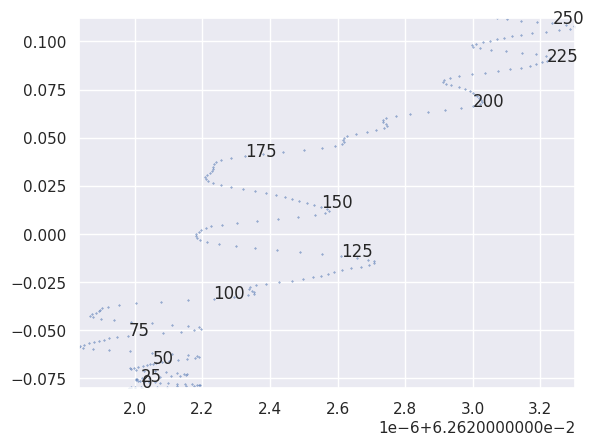

In [16]:
fig, ax = plt.subplots()
ax.scatter(c[:,0],c[:,1], marker=".", c='b', s=0.5)
ax.set_xlim(min(c[:,0]), max(c[:,0]))
ax.set_ylim(min(c[:,1]), max(c[:,1]))
for i in range(0,x,step):
    ax.annotate(str(i),(c[i,0],c[i,1]))
plt.show()

In [18]:
class MDTrSampler:
    def __init__(self, n_atoms, n_dim = 2, conv_size = 50, n_samples=1000, batch_size=100, manifold_size=64):
        self.n_dim = n_dim
        self.conv_size = conv_size
        self.n_atoms = n_atoms
        self.batch_size = batch_size
        self.l = manifold_size
        self.n_samples = n_samples
        self.bq = np.zeros((batch_size,n_atoms,3)) # batch queue
        self.total_samples = 0
        self.bq_index = 0
        self.Btp = np.zeros((n_atoms*3,self.l))
        self.strm_smplr = WeightedReservoirSampler(n_samples)
        self.last_Vt = None
    
    def traj_char(self, c, s):
        x = c.shape[0]
        # scaled data <-- not so much meaningful as we're doing l2 normalization later
        ps = np.mat(c[:,:self.n_dim]) * np.mat(np.diag(s[:self.n_dim]))
        # gradient or changes of each data point
        psd = ps[0:(x-1),:self.n_dim] - ps[1:x, :self.n_dim];
        
        # convoluted gradient --> smoothed gradient
        psdm = ndi.convolve(psd, np.ones((self.conv_size,2))/self.conv_size*2);
        # L2 normalized smoothed gradients --> now we focus on the angle of gradient only as atoms may move different speed 
        npsdm = np.divide(psdm, np.mat(np.sum(np.abs(psdm)**2,axis=-1)**(1./2)).T  * np.mat(np.ones((1,n_dim))))
        # Angle smoothing with the assumption that the overall angle can not be radically changed
        nmpsdm = ndi.convolve(npsdm, np.ones((self.conv_size,2))/self.conv_size*2);
        # Smoothed angle changes (accelerations)
        psdd = nmpsdm[0:(x-2)] - nmpsdm[1:(x-1)]
        # results for gradient of changes
        psdu = np.sum(abs(psd),axis=1)
        # results of smoothed normalized acceleration
        psddu = np.sum(abs(psdd),axis=1)
        prob_dist = (abs(psddu) / np.sum(psddu))
        return nmpsdm, psddu, prob_dist
    
    def strmML(self, t2):
        n_t = t2.shape[1]
        Ct = np.concatenate( (self.Btp, t2), axis = 1)
        Ct = Ct[:, ~(Ct==0).all(0)]

        Ut, St, Vt = svd_wrapper(Ct, self.l) #SVD_l(matrix)
        Ut_l = Ut[:, :self.l]
        St_l = St[:self.l] - St[self.l-1] # to be adaptive, added singular substraction
        Vt_l = Vt[:self.l, -n_t:]
        self.Btp= np.dot(Ut_l, np.diag(St_l))

        return Ut_l, St_l, Vt_l
    
    def batch_sampling(self, trace):
        (x,y,z) = trace.shape
        self.sampling_rate = float(self.n_samples) / float(x)
        t2 = trace.reshape((x, y*z),order='C')
        c,s,v = svd_wrapper(t2, 2, method='random')
        nmpsdm, psddu, prob_dist = self.traj_char(c,s) 
        total = 10**-10 + prob_dist[0]
        sampling_entries = int(x * self.sampling_rate)
        target = np.zeros((sampling_entries, y, z))
        time_stamps = np.zeros(sampling_entries)
        #output initialization: the first one should be added always
        target[0,:,:] = trace[0,:,:]
        time_stamps[0] = 0;
        t_idx = 1;
        for i in range(2,x):
            total = total + prob_dist[i-2];
            if(total > 1 / float(sampling_entries - 1)):
                target[t_idx,:,:] = trace[i,:,:]
                time_stamps[t_idx] = i
                total = total - 1 / float(sampling_entries-1);
                t_idx = t_idx + 1;
        return target, time_stamps
    
    
    def adaptive_sampling_update(self):
        t2 = self.bq[0:self.bq_index,:,:].reshape((self.bq_index, self.n_atoms*z),order='C').T
        Ut, s, VTt = self.strmML(t2)
        if self.last_Vt is None: # for the first time
            c = VTt.T
            self.strm_smplr.add(10**10,[0, self.bq[0,:,:]])
            nmpsdm, psddu, prob_dist = self.traj_char(c, s)
            sidx = self.total_samples - self.bq_index
            for i in range(2,self.bq_index):
                self.strm_smplr.add(psddu[i-2], [sidx+i, self.bq[i,:,:]])
        else:
            c =  np.concatenate( (self.last_Vt, VTt.T), axis = 0)
            nmpsdm, psddu, prob_dist = self.traj_char(c, s)
            sidx = self.total_samples - self.bq_index
            for i in range(0,self.bq_index):
                self.strm_smplr.add(psddu[i], [sidx+i, self.bq[i,:,:]])
                
        self.last_Vt = VTt.T[-2:,:] # for last two to start compare against
        
        

    def adaptive_sampling_step(self, dataframe_t):
        self.total_samples = self.total_samples + 1
        self.bq[self.bq_index] = dataframe_t
        self.bq_index = self.bq_index+1
        if self.bq_index == (self.batch_size):
            self.adaptive_sampling_update()
            self.bq_index = 0
        

In [19]:
mds = MDTrSampler(y, n_dim = 2, conv_size = 5, n_samples=100, batch_size=10, manifold_size=24)

nmpsdm, psddu, prob_dist = mds.traj_char(c,s)  

In [20]:
nmpsdm

array([[ 1.83290033,  1.68798506],
       [ 0.732375  ,  0.36517201],
       [-0.37030019, -0.97521062],
       [-1.4747852 , -2.31119708],
       [-2.58368202, -3.6150861 ],
       [-2.7129247 , -3.51099968],
       [-2.72205808, -3.49008276],
       [-2.7253825 , -3.48179331],
       [-2.72639885, -3.47920375],
       [-2.72533325, -3.4819032 ],
       [-2.72175857, -3.49079275],
       [-2.71596029, -3.504749  ],
       [-2.70806731, -3.52308322],
       [-2.69838742, -3.54465789],
       [-2.68782129, -3.56708864],
       [-2.67753834, -3.58786828],
       [-2.66875054, -3.60491982],
       [-2.66212402, -3.61736627],
       [-2.65824171, -3.62447415],
       [-2.65723911, -3.62627762],
       [-2.65874506, -3.62358874],
       [-2.66170451, -3.61829229],
       [-2.66536992, -3.61168038],
       [-2.66920566, -3.60466214],
       [-2.67297861, -3.59762043],
       [-2.67660601, -3.59068734],
       [-2.68034198, -3.58337716],
       [-2.68443559, -3.5751793 ],
       [-2.6887484 ,

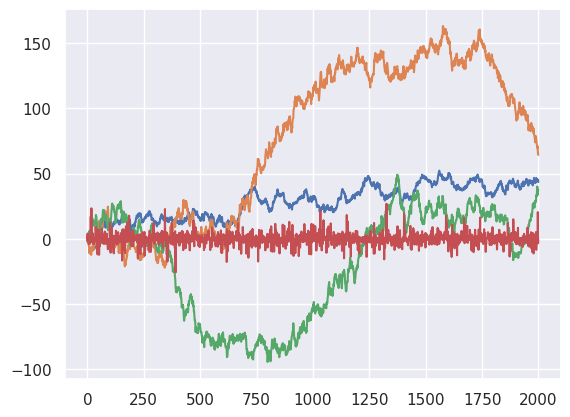

In [20]:
plt.plot(np.arange(0,2000),sample_x)
plt.plot(np.arange(0,2000),sample_y)
plt.plot(np.arange(0,2000),sample_z)
plt.plot(np.arange(0,2000),trace_1[1])
plt.show()

In [18]:
a_sparse, b_sparse = sparse.csr_matrix(sample_a), sparse.csr_matrix(sample_b)
sim_sparse = cosine_similarity(a_sparse, b_sparse, dense_output=True)
print(sim_sparse)

[[ 0.00798422  0.0113843  -0.0008589 ]
 [ 0.00767386 -0.04268317 -0.0078294 ]
 [-0.01395902 -0.00581703  0.04761105]]


In [19]:
sim_array = cosine_similarity(sample_a,sample_b,dense_output=True)
print(sim_array)

[[ 0.00798422  0.0113843  -0.0008589 ]
 [ 0.00767386 -0.04268317 -0.0078294 ]
 [-0.01395902 -0.00581703  0.04761105]]


In [67]:
def cp_vs_h(sample_x_0,sample_y_0,sample_z_0,h_start,h_end,step,delta):
    cps = []
    hs = []
    while h_start<h_end:
        cp = KCUSUM(sample_x_0,sample_x_1,sample_y_0,sample_y_1,h_start,delta=0)
        hs.append(h_start)
        cps.append(cp)
        h_start += step
        plt.plot(hs,cps)
        plt.xlabel('Value of h')
        plt.ylabel('Change points')

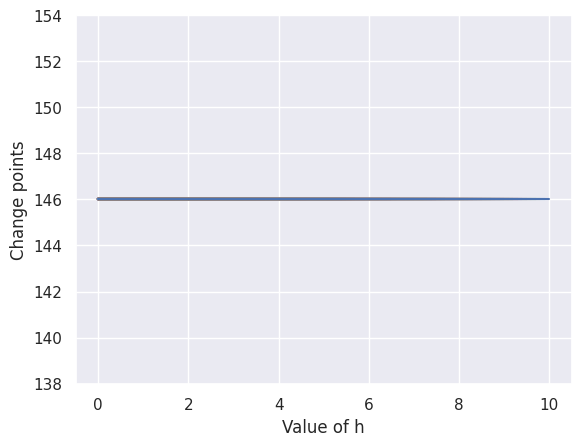

In [68]:
cp_vs_h(sample_x,sample_y,sample_z_0,0,10,0.1,0.05)
plt.show()